In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
payments_df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
payments_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
## Visualizing the current performance of the flagging
tp=payments_df[((payments_df["isFraud"]==1)&(payments_df["isFlaggedFraud"]==1))].shape[0]
fp=payments_df[(payments_df["isFraud"]==0)&(payments_df["isFlaggedFraud"]==1)].shape[0]
tn=payments_df[(payments_df["isFraud"]==0)&(payments_df["isFlaggedFraud"]==0)].shape[0]
fn=payments_df[(payments_df["isFraud"]==1) & (payments_df["isFlaggedFraud"]==0)].shape[0]
print(tp,fp,tn,fn)


16 0 6354407 8197


There are only 16 transactions which are correctly flagged as fraud. This is really bad performance. Maybe it is not worth it to keep the isFlaggedFraud column in our dataset

In [5]:
# Checking Class Balance
actual_fraud_count = tp+fn
actual_not_fraud_count = fp+tn
print(actual_fraud_count,actual_not_fraud_count)

8213 6354407


The dataset is highly imbalanced as fraud transactions are significantly lesser than the not fraud cases. Modelling a classification problem is significantly tougher due to imabalanced classes in the data potentially used for training 

<AxesSubplot:>

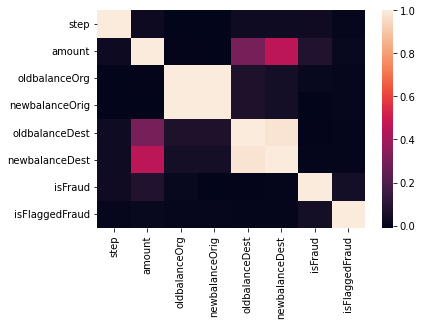

In [6]:
## Correlation Analysis
sns.heatmap(payments_df.corr())

In [9]:
## Two Digit Test
payments_df.head(5)
payments_df[payments_df["isFraud"]==1]["type"].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

We would like to visualize patterns in fraudulent transactions. Hence we reduce the sample space to only "cash_out and "transfer" cases

In [12]:
payments_df[(payments_df["type"] =="CASH_OUT") | (payments_df["type"] =="TRANSFER")]["type"].value_counts()
sliced_payments_df = payments_df[(payments_df["type"] =="CASH_OUT") | (payments_df["type"] =="TRANSFER")]

### Two Digit Test

In [17]:
sliced_payments_df['amount'].describe()
## Filtering transactions to only keep those above 10 USD
sliced_payments_df = sliced_payments_df[sliced_payments_df["amount"]>10]

In [18]:
sliced_payments_df["amt_first_two_digits"] = sliced_payments_df["amount"].astype('str').str[:2].astype(int)
sliced_payments_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amt_first_two_digits
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,18
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,18
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,22
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,21
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,31


<AxesSubplot:title={'center':'Histogram of First 2 digits of Receipt Amount'}, xlabel='First Two Digits of transaction| Amount', ylabel='Count of Occurences/Frequency of Record'>

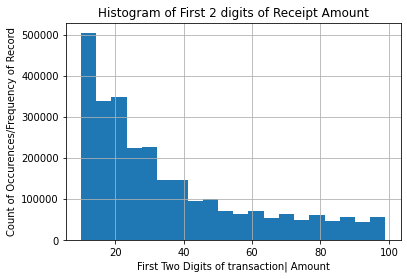

In [19]:
plt=sliced_payments_df['amt_first_two_digits'].plot(kind='hist', 
                                label ='Frequency of first 2 digits',title='Histogram of First 2 digits of Receipt Amount',
                                grid='line',
                                bins=20#bin size of 5. Each value interval in x is of 5
                                
                               )
plt.set_xlabel("First Two Digits of transaction| Amount")
plt.set_ylabel("Count of Occurences/Frequency of Record")
plt

#### Conclusion of First 2 digit test:- 

#### As seen above it is evident that the above dataset approximately conforms to the 2 digit test(first order testing) of Benford's Law considering the trend line observed.

There is a small non conformity for case '10', we see that '15' has a higher frequency than '10'. That needs to be further analyzed for any natural biases while collecting data. It is possible that there is a minimum qualification limit for a receipt amount to be recorded is that it starts with '20' as its first 2 digits. However until then, we can  say that it only approximately conforms to Benford's law and the cause of the bias needs to be understood further.

For visualizations,proportions and explanation of Benford's law please click here https://en.wikipedia.org/wiki/Benford%27s_law

In [25]:
pd.DataFrame(sliced_payments_df[sliced_payments_df["isFraud"]==1]["amt_first_two_digits"].value_counts()).sort_values(by = ['amt_first_two_digits'], ascending = False).head(20)

,amt_first_two_digits
10,604
11,276
12,256
14,247
13,233
17,222
15,220
21,212
16,208
20,175


* Inconsistencies noted in 20 do not seem to be occuring due to any fraud and could be a minimum condition for the transaction to be recorded.

### Z-Statistic Testing
To measure the significance of difference/conformity of the 2 digit test in Benford's law, it is imperative to take up the z-statistic test. The basic variables against which impact and help us understand the significance are:-
* magnitude of difference between actual proportion of the 2 digits and the expected proportion of the 2 digits(|AP-EP|)
* size of the dataset(N)
* magnitude of the expected proportion(EP)

                              (|AP-EP|-(1/2N))
                    Z =     ___________________
                            
                            ((EP(1-EP)/2N)^0.5)